In [2]:
import torch
from torch.utils.data import DataLoader
from supervised_fine_tuning import (
    load_dataset, load_model, collate_fn, train, test_model_generation
)

# Define parameters
model_name = "gpt2-medium"
dataset_path = "./instruction-data-with-preference.json"
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 2
epochs = 10
learning_rate = 2e-6
max_length = 128
save_path = "my-supervised-finetuned-gpt2"

dataset_split = load_dataset(dataset_path)
train_dataset, eval_dataset = dataset_split["train"], dataset_split["test"]
print("training and evaluation split Done.")

model, tokenizer = load_model(model_name, device)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=lambda b: collate_fn(b, tokenizer, max_length=max_length, device=device)
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, shuffle=False,
    collate_fn=lambda b: collate_fn(b, tokenizer, max_length=max_length, device=device)
)

train(model, tokenizer, train_dataloader, eval_dataloader, epochs=epochs, learning_rate=learning_rate, save_path=save_path)

test_model_generation(model, tokenizer, eval_dataset, num_samples=2)


training and evaluation split Done.


/home/infres/benedetti-23/anaconda3/envs/myenv/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 440/440 [00:57<00:00,  7.69it/s]



[Epoch 1] Train Loss = 2.1662, Eval Loss = 1.5279, Eval PPL = 4.6087



Epoch 2/10: 100%|██████████| 440/440 [00:57<00:00,  7.67it/s]



[Epoch 2] Train Loss = 1.5302, Eval Loss = 1.3727, Eval PPL = 3.9459



Epoch 3/10: 100%|██████████| 440/440 [00:57<00:00,  7.69it/s]



[Epoch 3] Train Loss = 1.3692, Eval Loss = 1.2953, Eval PPL = 3.6523



Epoch 4/10: 100%|██████████| 440/440 [00:57<00:00,  7.66it/s]



[Epoch 4] Train Loss = 1.2577, Eval Loss = 1.2487, Eval PPL = 3.4860



Epoch 5/10: 100%|██████████| 440/440 [00:57<00:00,  7.68it/s]



[Epoch 5] Train Loss = 1.1834, Eval Loss = 1.2170, Eval PPL = 3.3772



Epoch 6/10: 100%|██████████| 440/440 [00:57<00:00,  7.66it/s]



[Epoch 6] Train Loss = 1.1277, Eval Loss = 1.1990, Eval PPL = 3.3168



Epoch 7/10: 100%|██████████| 440/440 [00:57<00:00,  7.65it/s]



[Epoch 7] Train Loss = 1.0705, Eval Loss = 1.1844, Eval PPL = 3.2686



Epoch 8/10: 100%|██████████| 440/440 [00:57<00:00,  7.65it/s]



[Epoch 8] Train Loss = 1.0193, Eval Loss = 1.1750, Eval PPL = 3.2380



Epoch 9/10: 100%|██████████| 440/440 [00:57<00:00,  7.67it/s]



[Epoch 9] Train Loss = 0.9700, Eval Loss = 1.1682, Eval PPL = 3.2163



Epoch 10/10: 100%|██████████| 440/440 [00:57<00:00,  7.66it/s]



[Epoch 10] Train Loss = 0.9356, Eval Loss = 1.1622, Eval PPL = 3.1970

Model saved to my-supervised-finetuned-gpt2
-------------- EXAMPLE --------------
PROMPT:
Instruct: Generate a sentence using the word 'optimistic'.

Answer:
GENERATED:
Instruct: Generate a sentence using the word 'optimistic'.

Answer: Her optimism was contagious.
REFERENCE:
He remained quite optimistic despite the challenges he faced.
-------------------------------------

-------------- EXAMPLE --------------
PROMPT:
Instruct: Translate 'hello' into Japanese.

Answer:
GENERATED:
Instruct: Translate 'hello' into Japanese.

Answer: The Japanese translation of 'hello' is kindly provided in the form of 'I'd like to thank you for kindly taking the time to visit.'
REFERENCE:
The Japanese translation of 'hello' is 'こんにちは' (Konnichiwa).
-------------------------------------



## DPO 

In [4]:
import torch
from torch.utils.data import DataLoader
from dpo_finetuning import (
    load_dataset, load_models, collate_fn, train_dpo
)

dataset_path = "./instruction-data-with-preference.json"
device = "cuda:2" if torch.cuda.is_available() else "cpu"
batch_size = 10
epochs = 5
learning_rate = 2e-6
save_path = "dpo-finetuned-instruct-gpt2"

dataset_split = load_dataset(dataset_path)
train_dataset, eval_dataset = dataset_split["train"], dataset_split["test"]

policy_model_name = "my-supervised-finetuned-gpt2"
ref_model_name = "gpt2-medium"
model, ref_model, tokenizer = load_models(policy_model_name, ref_model_name, device)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=lambda b: collate_fn(b, tokenizer, device=device)
)
metrics_total = {}

for beta in [0.3, 0.7, 1.0]:
    print(f"Training with beta={beta}")
    metrics = train_dpo(model, ref_model, tokenizer, train_dataloader, device=device, epochs=epochs, beta=beta, lr=learning_rate, save_path=save_path)
    metrics_total[beta] = metrics


Training with beta=0.3


Epoch 5/5: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]


Model saved to dpo-finetuned-instruct-gpt2
Training with beta=0.7


Epoch 5/5: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]


Model saved to dpo-finetuned-instruct-gpt2
Training with beta=1.0


Epoch 5/5: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]


Model saved to dpo-finetuned-instruct-gpt2


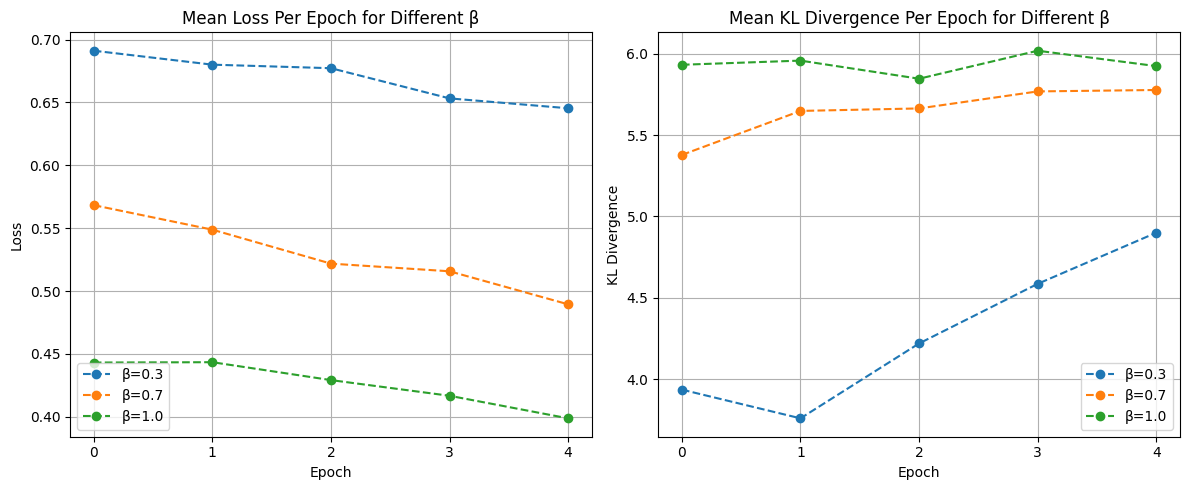

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_mean_per_epoch(values, steps_per_epoch):
    """Computes the mean per epoch by averaging over steps in each epoch."""
    num_epochs = len(values) // steps_per_epoch  
    epoch_means = [
        np.mean(values[i * steps_per_epoch:(i + 1) * steps_per_epoch]) 
        for i in range(num_epochs)
    ]
    return epoch_means, list(range(num_epochs))  

steps_per_epoch = len(train_dataloader) 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for beta, metrics in metrics_total.items():
    mean_loss_per_epoch, epochs = compute_mean_per_epoch(metrics["step_loss"], steps_per_epoch)
    plt.plot(epochs, mean_loss_per_epoch, marker="o", linestyle="--", label=f"β={beta}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean Loss Per Epoch for Different β")
plt.legend()
plt.grid()
plt.xticks(epochs)  

plt.subplot(1, 2, 2)
for beta, metrics in metrics_total.items():
    mean_kl_per_epoch, epochs = compute_mean_per_epoch(metrics["step_kl"], steps_per_epoch)
    plt.plot(epochs, mean_kl_per_epoch, marker="o", linestyle="--", label=f"β={beta}")

plt.xlabel("Epoch")
plt.ylabel("KL Divergence")
plt.title("Mean KL Divergence Per Epoch for Different β")
plt.legend()
plt.grid()
plt.xticks(epochs) 

plt.tight_layout()
plt.show()

plt.show()


## Evaluation


Evaluating DPO Model...
DPO Model | Beta=0.10 => Win Rate: 58.40%
DPO Model | Beta=0.25 => Win Rate: 56.80%
DPO Model | Beta=0.50 => Win Rate: 58.00%
DPO Model | Beta=0.75 => Win Rate: 58.60%
DPO Model | Beta=1.00 => Win Rate: 56.80%

Evaluating SFT Model...
SFT Model | Beta=0.10 => Win Rate: 51.40%
SFT Model | Beta=0.25 => Win Rate: 52.40%
SFT Model | Beta=0.50 => Win Rate: 51.20%
SFT Model | Beta=0.75 => Win Rate: 51.00%
SFT Model | Beta=1.00 => Win Rate: 46.60%


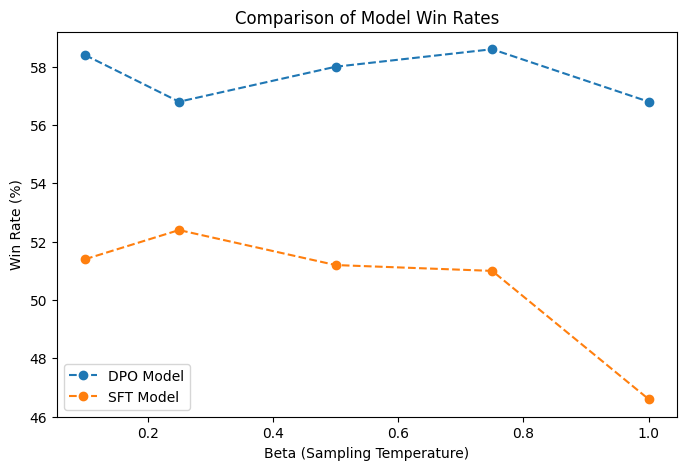

In [4]:
from evaluation import load_models, load_data, prepare_eval_pairs, evaluate_model, plot_results, run_evaluation

model_paths = {
    "DPO Model": "dpo-finetuned-instruct-gpt2",
    "SFT Model": "my-supervised-finetuned-gpt2"
}

json_path = "./instruction-data-with-preference.json"

run_evaluation(model_paths, json_path)